In [3]:
import numpy as np
import pandas as pd
from shutil import copyfile
from astropy.cosmology import Planck13 as cosmo
import fsps
from matplotlib import gridspec
from astropy.io import fits
from astropy import wcs
from astropy.table import Table
from sim_engine import Scale_model
from spec_tools import Source_present, Oldest_galaxy, Sig_int, Smooth
from spec_stats import Smooth
from spec_exam import Gen_spec
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model
from sim_engine import forward_model_grism

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [8]:
flist = glob('../plots/bestfits/*')

upd_field = [os.path.basename(U).split('_')[0] for U in flist]
upd_galaxy = np.array([os.path.basename(U.replace('.png','')).split('_')[1] for U in flist]).astype(np.int)

# remove agn

In [3]:
GSD_cat = Table.read(hpath + 'Data/3D-HST/CATALOGS/goodss_3dhst.v4.1.cats/Catalog/goodss_3dhst.v4.1.cat',format='ascii')
GND_cat = Table.read(hpath + 'Data/3D-HST/CATALOGS/goodsn_3dhst.v4.1.cats/Catalog/goodsn_3dhst.v4.1.cat',format='ascii')

agn_ra=fits.open('../../../Clear_data/AGN_catalog/tbl04.fits')[1].data['GOODSS_RA']
agn_dec=fits.open('../../../Clear_data/AGN_catalog/tbl04.fits')[1].data['GOODSS_DEC']

FileNotFoundError: [Errno 2] No such file or directory: '/Users/Vince.ec/Data/3D-HST/CATALOGS/goodss_3dhst.v4.1.cats/Catalog/goodss_3dhst.v4.1.cat'

In [8]:
def Match_agn(gal_ra, gal_dec, agn_ra, agn_dec):
    r = (1. / 60 / 60) * 0.5    
    in_out = np.repeat('in',len(gal_ra))          
    for i in range(len(gal_ra)):
        cosr = np.sin(np.radians(gal_dec[i])) * np.sin(np.radians(agn_dec)) + np.cos(np.radians(gal_dec[i]))\
                * np.cos(np.radians(agn_dec)) * np.cos(np.radians(gal_ra[i]) - np.radians(agn_ra))
        rad = np.arccos(cosr)
        rad = np.degrees(rad)
        for ii in range(len(rad)):
            if rad[ii] < r:
                in_out[i]= 'out'
    return in_out

In [11]:
sra = [] ; sdec = []
nra = [] ; ndec = []

for i in range(len(field)):
    if field[i] == 'GSD':
        sra.append(GSD_cat[galaxy[i] - 1]['ra'])
        sdec.append(GSD_cat[galaxy[i] - 1]['dec'])   
    if field[i] == 'GND':
        nra.append(GND_cat[galaxy[i] - 1]['ra'])
        ndec.append(GND_cat[galaxy[i] - 1]['dec']) 

In [12]:
south_agn = Match_agn(sra,sdec,agn_ra,agn_dec)

In [14]:
n_agn_cat=Table.read('../../../Clear_data/AGN_catalog/apjs523032t3_mrt.txt',format='ascii')

In [15]:
RA=np.array([n_agn_cat['RAh'].data, n_agn_cat['RAm'].data,n_agn_cat['RAs'].data]).T
DEC=np.array([n_agn_cat['DEd'].data,n_agn_cat['DEm'].data,n_agn_cat['DEs'].data]).T

def Convert_RA_DEC_to_deg(ra,dec):
    R=15*(ra[0]+ra[1]/60.+ra[2]/3600.)
    D=dec[0]+dec[1]/60.+dec[2]/3600.
    return R,D

nra_agn,ndec_agn=np.zeros([2,len(RA)])

for i in range(len(RA)):
    nra_agn[i],ndec_agn[i]=Convert_RA_DEC_to_deg(RA[i],DEC[i])

In [16]:
north_agn = Match_agn(nra,ndec,nra_agn,ndec_agn)

In [17]:
north_agn

array(['in', 'in', 'in', 'ou', 'in', 'in', 'in', 'in', 'in', 'in', 'in',
       'in', 'in', 'in', 'in', 'in', 'in', 'in', 'ou', 'in', 'in', 'in',
       'in', 'in', 'in', 'in', 'in', 'in', 'in', 'in', 'in', 'in', 'in',
       'in', 'in', 'in', 'in', 'in', 'in', 'in', 'in'], dtype='<U2')

In [18]:
south_agn

array(['ou', 'in', 'in', 'in', 'in', 'in', 'in', 'in', 'in', 'in', 'in',
       'ou', 'in', 'in', 'in', 'in', 'in', 'ou', 'in', 'in'], dtype='<U2')

In [23]:
u=0
v=0

upd_field = []
upd_galaxy = []


for i in range(len(field)):
    if field[i] == 'GSD':
        if south_agn[u] == 'ou':
            print(field[i], galaxy[i], 'out')
        else:
            upd_field.append(field[i])
            upd_galaxy.append(galaxy[i])
            
        u+=1
        
    if field[i] == 'GND':
        if north_agn[v] == 'ou':
            print(field[i], galaxy[i], 'out')
            
        else:
            upd_field.append(field[i])
            upd_galaxy.append(galaxy[i])
        v+=1

GND 15490 out
GND 23631 out
GSD 35046 out
GSD 42113 out
GSD 46846 out


In [5]:
def forward_model_all_beams(beams, trans, in_wv, model_wave, model_flux):
    FL = np.zeros([len(beams),len(in_wv)])

    for i in range(len(beams)):
        mwv, mflx = forward_model_grism(beams[i], model_wave, model_flux)
        FL[i] = interp1d(mwv, mflx)(in_wv)
        FL[i] /= trans[i]

    return np.mean(FL.T,axis=1)


def Full_forward_model(spec, wave, flux, specz):
    Bmfl = forward_model_all_beams(spec.Bbeam, spec.Btrans, spec.Bwv, wave * (1 + specz), flux)
    Rmfl = forward_model_all_beams(spec.Rbeam, spec.Rtrans, spec.Rwv, wave * (1 + specz), flux)
    Pmfl = spec.Sim_phot_mult(wave * (1 + specz),flux)

    return Bmfl, Rmfl, Pmfl

def Full_scale(spec, Pmfl):
    PC = Scale_model(spec.Pflx, spec.Perr, Pmfl)
    return PC

In [6]:
sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(1), sfh = 3, dust_type = 1)

In [9]:
PWV , BWV, RWV =[[],[],[]]
PIE , BIE, RIE =[[],[],[]]
PE , BE, RE =[[],[],[]]
PWV_rf , BWV_rf, RWV_rf =[[],[],[]]


for i in range(len(upd_field)):
    dres = np.load('../data/out_dict/{0}_{1}_nested_Bfit.npy'.format(upd_field[i], upd_galaxy[i])).item()
    bfZ, bft, bftau1, bftau2, bftau3, bftau4, bftau5, bftau6, bfz, bfd =  dres.samples[np.where(dres.logl == np.max(dres.logl))[0][0]]
    
    sp.params['logzsol'] = np.log10( bfZ )
    sp.params['dust2'] = bfd
    sp.set_tabular_sfh(np.array([0.1, 0.5, 1, 2, 4, 7]),np.array([bftau1, bftau2, bftau3, bftau4, bftau5, bftau6]))

    wave,flux = sp.get_spectrum(tage = bft,peraa=True)
    
    Gs = Gen_spec(upd_field[i],upd_galaxy[i], bfz,
               g102_lims=[8300, 11500], g141_lims=[11100, 16500],mdl_err = False, instr_err = False,
            phot_errterm = 0.03, decontam = True)
    
    Pmfl = Gs.Sim_phot_mult(wave * (1 + bfz),flux)

    PC= Scale_model(Gs.Pflx,Gs.Perr,Pmfl)
    
    PWV.extend(Gs.Pwv)
    PWV_rf.extend(Gs.Pwv / (1 + bfz))
    
    PIE.extend(((Gs.Pflx - PC*Pmfl) / Gs.Pflx)**2)
    PE.extend(((Gs.Perr) / Gs.Pflx)**2)
    
    if Gs.g102: 
        Bmfl = forward_model_all_beams(Gs.Bbeam, Gs.Btrans, Gs.Bwv, wave * (1 + bfz), flux)
        Bscale = Scale_model(Gs.Bfl, Gs.Ber, PC*Bmfl)

        BWV.extend(Gs.Bwv)
        BWV_rf.extend(Gs.Bwv/ (1 + bfz))
        
        BIE.extend((((Gs.Bfl / Bscale )- PC*Bmfl) / (Gs.Bfl / Bscale))**2)
        BE.extend((Gs.Ber/Gs.Bfl)**2)

    if Gs.g141:
        Rmfl = forward_model_all_beams(Gs.Rbeam, Gs.Rtrans, Gs.Rwv, wave * (1 + bfz), flux)
        Rscale = Scale_model(Gs.Rfl, Gs.Rer, PC*Rmfl)

        RWV.extend(Gs.Rwv)
        RWV_rf.extend(Gs.Rwv/ (1 + bfz))
        RIE.extend((((Gs.Rfl / Rscale) - PC*Rmfl) / (Gs.Rfl / Rscale))**2)
        RE.extend((Gs.Rer/Gs.Rfl)**2)

        
#     plt.figure(figsize = [15,6])
    
#     if Gs.g102: 
#         plt.errorbar(np.log10(Gs.Bwv_rf),Gs.Bfl*1E18 / Bscale,Gs.Ber*1E18/ Bscale,
#                         linestyle='None', marker='o', markersize=3, color='#377eb8')
#         plt.plot(np.log10(Gs.Bwv_rf), PC*Bmfl*1E18, 'k', zorder=5)

#     if Gs.g141:
#         plt.errorbar(np.log10(Gs.Rwv_rf),Gs.Rfl*1E18/ Rscale,Gs.Rer*1E18/ Rscale,
#                         linestyle='None', marker='o', markersize=3, color='#e41a1c')
#         plt.plot(np.log10(Gs.Rwv_rf), PC*Rmfl*1E18, 'k', zorder=5)

#     plt.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx*1E18,Gs.Perr*1E18,
#                                      linestyle='None', marker='p', markersize=15, color='#984ea3')
#     plt.plot(np.log10(Gs.Pwv_rf), PC*Pmfl*1E18, 'ko', zorder=5)
    
#     plt.xticks(np.log10([1000,2500,5000,7500,10000,25000]),[1000,2500,5000,7500,10000,25000])

#     plt.savefig('../plots/bestfits/{0}_{1}.png'.format(upd_field[i], upd_galaxy[i]), bbox_inches = 'tight')

        

cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


missing g102


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


missing g102


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


missing g141
cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


missing g141
cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


missing g141
cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


missing g141
cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


missing g102


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


missing g102


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


In [217]:
IDP = np.argsort(PWV)
IDB = np.argsort(BWV)
IDR = np.argsort(RWV)

In [218]:
orderedpwv = list(set(PWV))

In [219]:
intrerr = []
nerr = []

for i in orderedpwv:
    ie = []
    ne = []
    for ii in IDP:
        if i == PWV[ii]:
            ie.append(PIE[ii])
            ne.append(PE[ii])
    intrerr.append(ie)
    nerr.append(ne)

In [220]:
mie = [np.median(U) for U in intrerr] 
me = [np.median(U) for U in nerr] 

MIE = np.array(mie) - np.array(me)
MIE[MIE < 0] = 0

([<matplotlib.axis.XTick at 0x1a7c7ade80>,
 <a list of 6 Text xticklabel objects>)

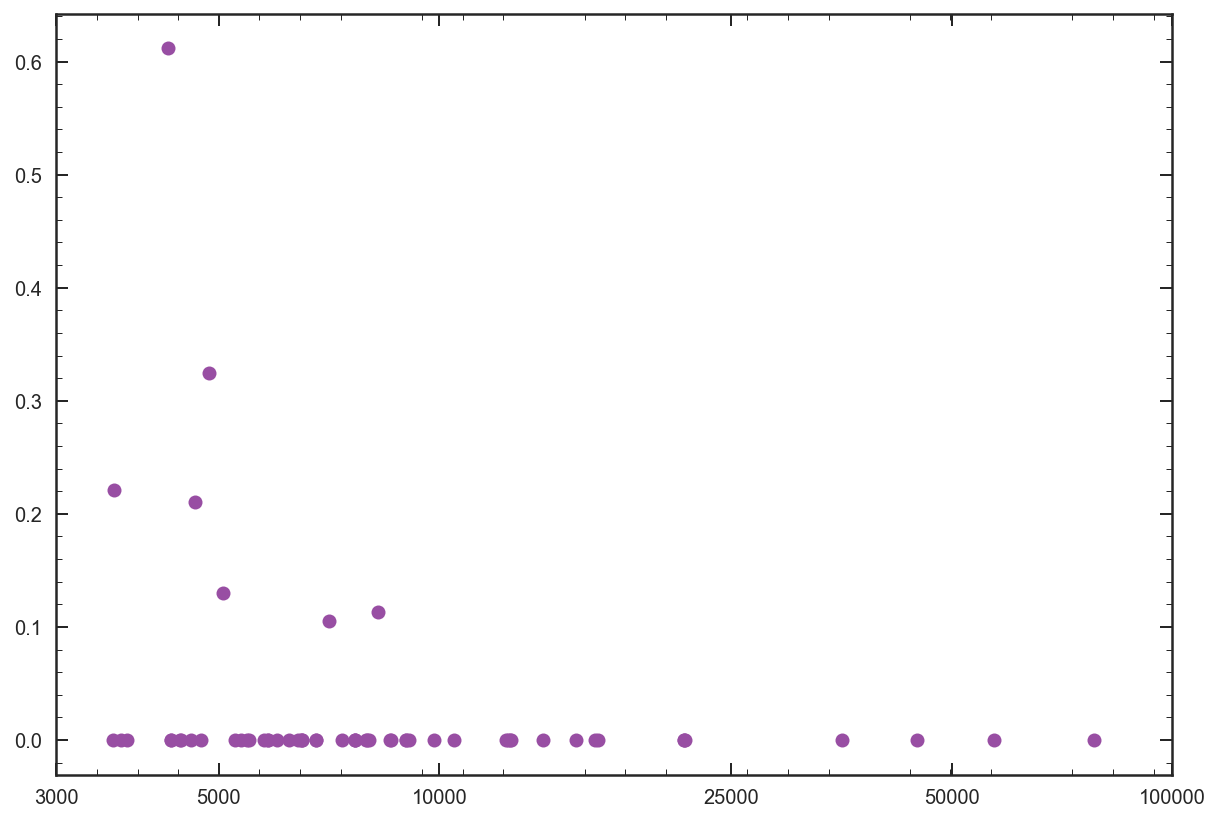

In [221]:
plt.figure(figsize=[10,7])
plt.plot(np.log10(orderedpwv), np.sqrt(MIE), 'o', color='#984ea3')
plt.xticks(np.log10([3000,5000,10000,25000,50000,100000]),[3000,5000,10000,25000,50000,100000])

In [14]:
def Run_bin_stat(wv,tmp,bin_size):
    wv = wv[tmp**2 > 0]
    tmp = tmp[tmp**2 > 0]
    
    
    wv_med = [] ; wv_mean = [] ; binned_data = []

    low_lim = min(wv)
    while low_lim <= max(wv):
        IDX = [U for U in range(len(wv)) if low_lim <= wv[U] < low_lim + bin_size]
        wv_med.append(np.median(wv[IDX]))
        wv_mean.append(np.median(low_lim + bin_size / 2))
        binned_data.append(np.median(tmp[IDX]))
        low_lim += bin_size
    return np.array(wv_med), np.array(wv_mean), np.array(binned_data)

In [223]:
BWV_med, BWV_mean, BIE_bin = Run_bin_stat(np.array(BWV)[IDB], np.array(BIE)[IDB],100)
BWV_med, BWV_mean, BE_bin = Run_bin_stat(np.array(BWV)[IDB], np.array(BE)[IDB],100)

RWV_med, RWV_mean, RIE_bin = Run_bin_stat(np.array(RWV)[IDR], np.array(RIE)[IDR],100)
RWV_med, RWV_mean, RE_bin = Run_bin_stat(np.array(RWV)[IDR], np.array(RE)[IDR],100)

In [224]:
intr_err_b = BIE_bin - BE_bin
intr_err_r = RIE_bin - RE_bin

# intr_err_b[intr_err_b < 0] = 0
# intr_err_r[intr_err_r < 0] = 0

In [225]:
rwv = np.arange(min(RWV), max(RWV) + 500, 500)
rief = [0.18, 0.09, 0.01,0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.03, 0.15, 0.18]

rwvs = np.arange(min(RWV), max(RWV) + 10, 5)
irief = interp1d(rwv,rief)(rwvs)

ValueError: x and y arrays must be equal in length along interpolation axis.

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


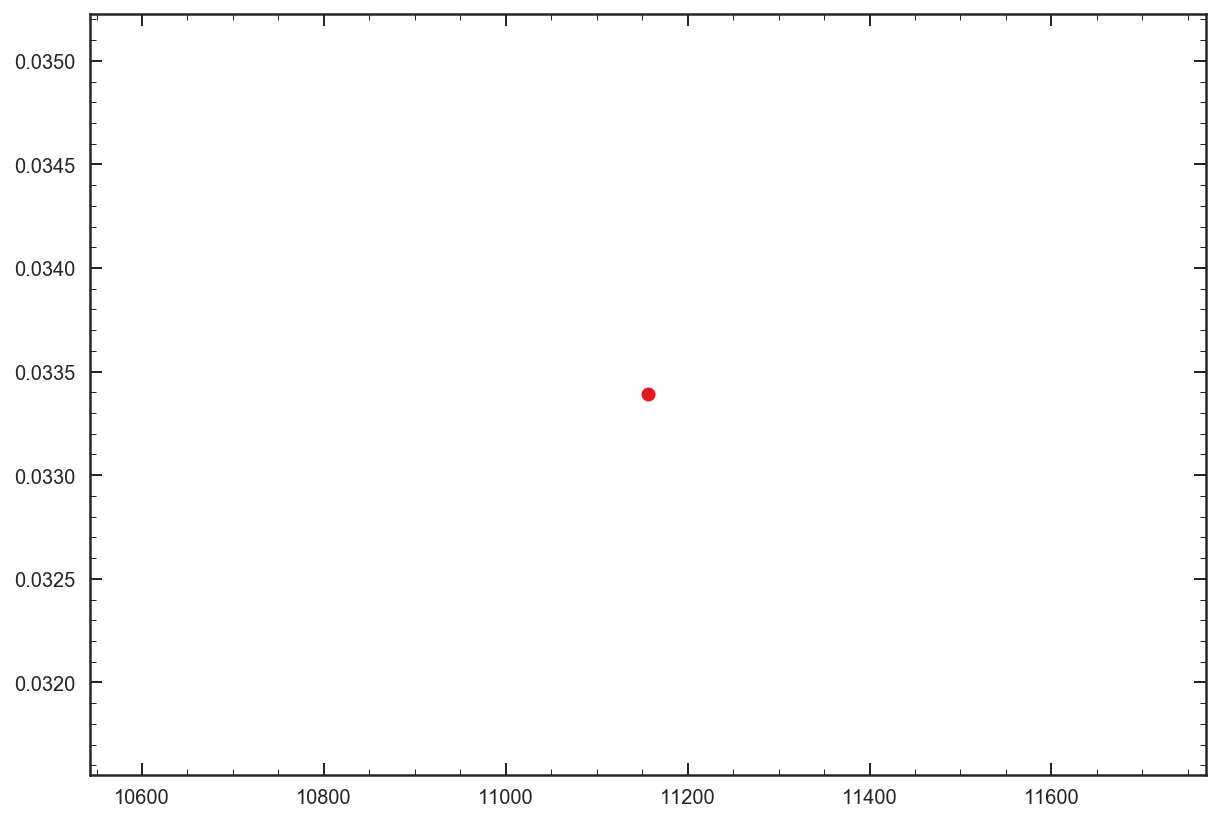

In [226]:
plt.figure(figsize=[10,7])

plt.plot(BWV_mean, np.sqrt(intr_err_b), 'o', color='#377eb8')

plt.plot(RWV_mean, np.sqrt(intr_err_r), 'o', color='#e41a1c')
# plt.plot(rwv,rief, 'k')
# plt.plot(rwvs, Smooth(irief,rwvs,100), 'c', linewidth = 5, alpha = 0.3)

In [15]:
# np.save('../templates/intr_EF_phot',[orderedpwv, np.sqrt(MIE)])
# np.save('../templates/intr_EF_g141',[rwvs, Smooth(irief,rwvs,100)])

In [10]:
IDPR = np.argsort(PWV_rf)
IDBR = np.argsort(BWV_rf)
IDRR = np.argsort(RWV_rf)

In [228]:
PWVR_med, PWVR_mean, PME_bin = Run_bin_stat(np.log10(PWV_rf)[IDPR], np.array(PIE)[IDPR],.01)
PWVR_med, PWVR_mean, PE_bin = Run_bin_stat(np.log10(PWV_rf)[IDPR], np.array(PE)[IDPR],.01)

BWVR_med, BWVR_mean, BME_bin = Run_bin_stat(np.array(BWV_rf)[IDBR], np.array(BIE)[IDBR],100)
BWVR_med, BWVR_mean, BE_bin = Run_bin_stat(np.array(BWV_rf)[IDBR], np.array(BE)[IDBR],100)

RWVR_med, RWVR_mean, RME_bin = Run_bin_stat(np.array(RWV_rf)[IDRR], np.array(RIE)[IDRR],100)
RWVR_med, RWVR_mean, RE_bin = Run_bin_stat(np.array(RWV_rf)[IDRR], np.array(RE)[IDRR],100)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [20]:
PWM = np.array(PWV_rf)[IDPR]
PIE = np.array(PIE)[IDPR]
PE = np.array(PE)[IDPR]

BWM = np.array(BWV_rf)[IDBR]
BIE = np.array(BIE)[IDBR]
BE = np.array(BE)[IDBR]

RWM = np.array(RWV_rf)[IDRR]
RIE = np.array(RIE)[IDRR]
RE = np.array(RE)[IDRR]

# PWM = PWM[PIM**2 > 0]
# PIE = PIE[PIE**2 > 0]
# PE = PE[PIE**2 > 0]

# BWM = BWM[BIM**2 > 0]
# BIM = BIM[BIM**2 > 0]
# RWM = RWM[RIM**2 > 0]
# RIM = RIM[RIM**2 > 0]

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


(0, 1)

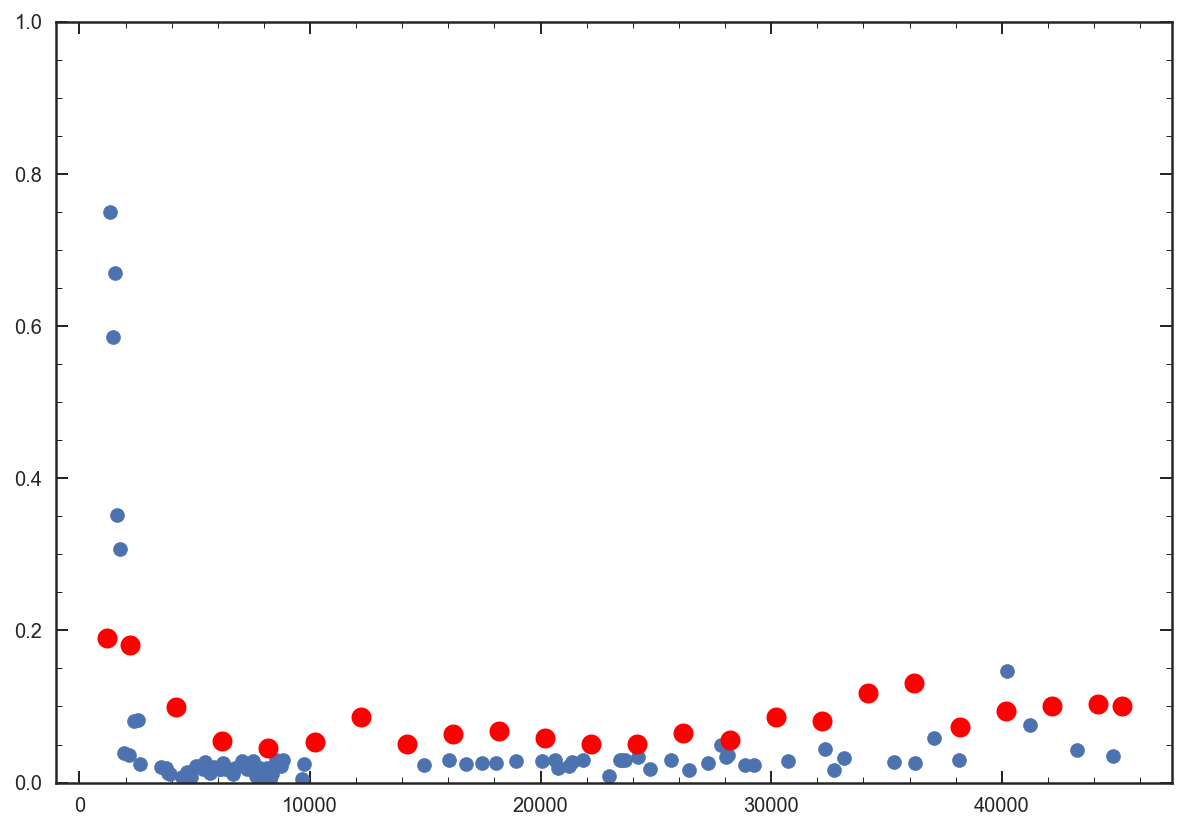

In [51]:
P_med, P_mean, PI_bin = Run_bin_stat(PWM, PIE,100)
P_med, P_mean, P_bin = Run_bin_stat(PWM, PE,100)

plt.figure(figsize=[10,7])
# plt.scatter(PWM, PIE)
# plt.scatter(PWM, PE, marker='*')
# plt.scatter(P_mean, PI_bin)
# plt.scatter(P_mean, P_bin)
plt.scatter(P_mean, np.sqrt(P_bin - PI_bin))
plt.plot(AW, AI, 'o', color='r',ms=10)

plt.ylim(0,1)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


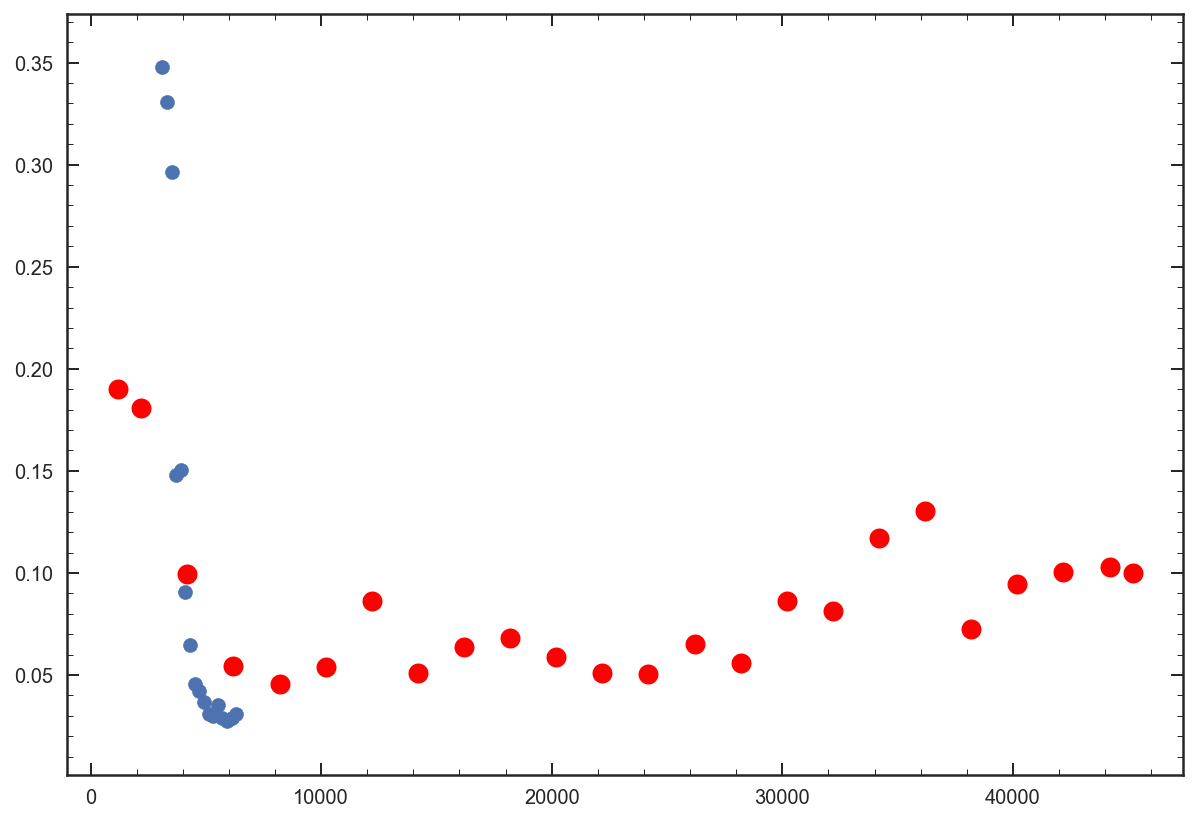

In [52]:
B_med, B_mean, BI_bin = Run_bin_stat(BWM, BIE,200)
B_med, B_mean, B_bin = Run_bin_stat(BWM, BE,200)

plt.figure(figsize=[10,7])
# plt.scatter(PWM, PIE)
# plt.scatter(PWM, PE, marker='*')
# plt.scatter(P_mean, PI_bin)
# plt.scatter(P_mean, P_bin)
plt.scatter(B_mean, np.sqrt(B_bin - BI_bin))
plt.plot(AW, AI, 'o', color='r',ms=10)

# plt.ylim(0,1)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


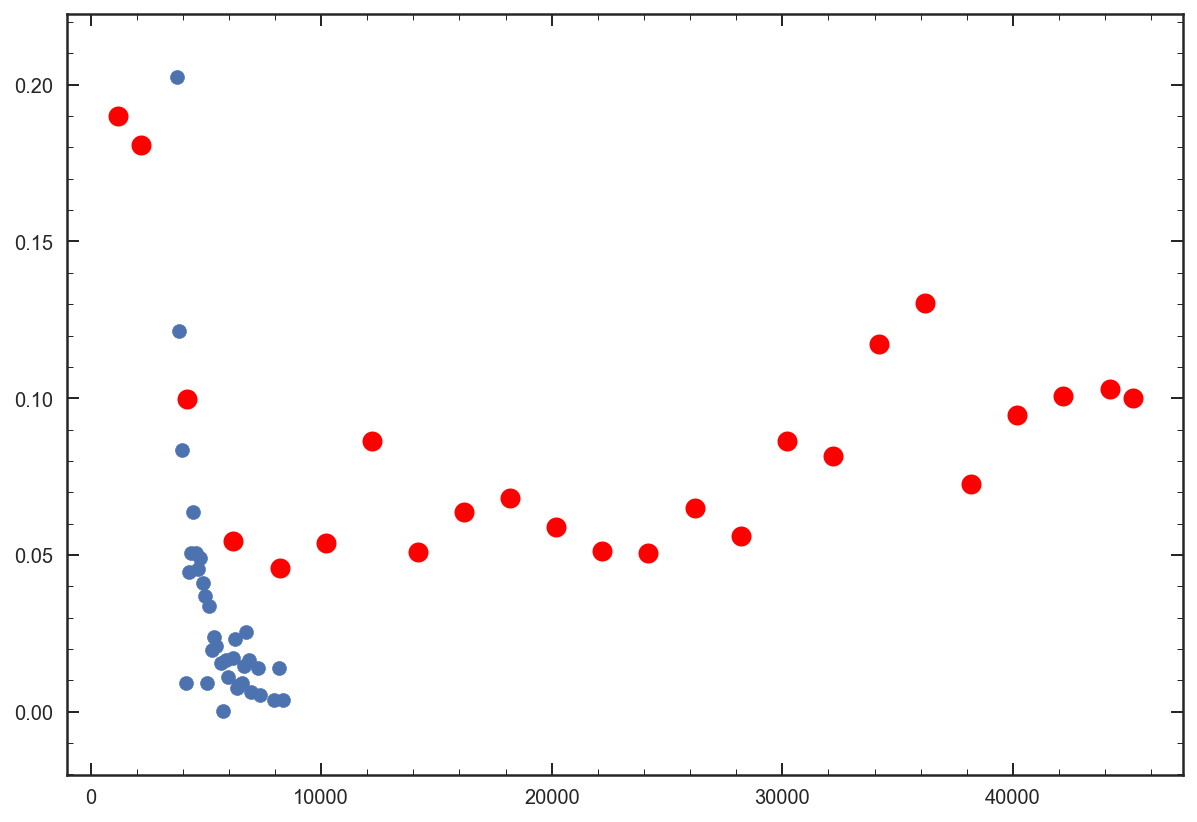

In [53]:
R_med, R_mean, RI_bin = Run_bin_stat(RWM, RIE,100)
R_med, R_mean, R_bin = Run_bin_stat(RWM, RE,100)

plt.figure(figsize=[10,7])
# plt.scatter(PWM, PIE)
# plt.scatter(PWM, PE, marker='*')
# plt.scatter(P_mean, PI_bin)
# plt.scatter(P_mean, P_bin)
plt.scatter(R_mean, np.sqrt(R_bin - RI_bin))
plt.plot(AW, AI, 'o', color='r',ms=10)

# plt.ylim(0,1)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


(0, 1)

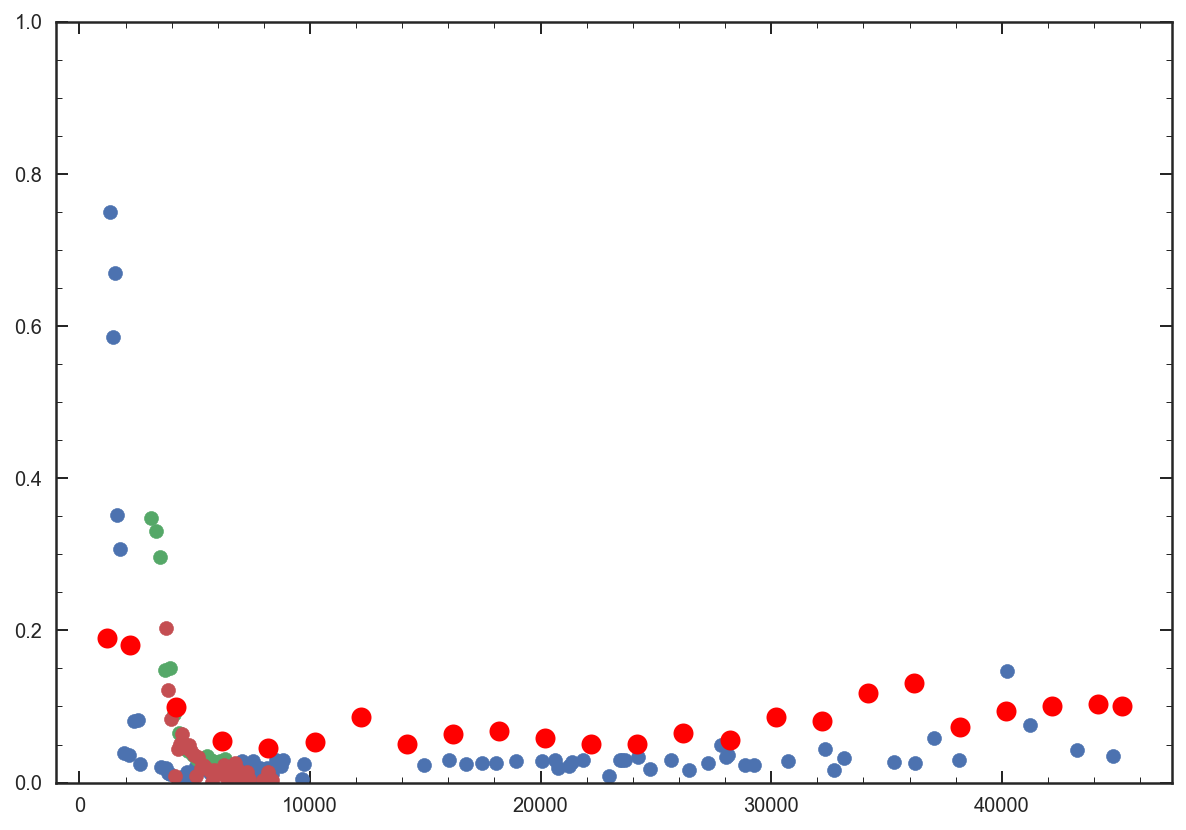

In [56]:
plt.figure(figsize=[10,7])
plt.scatter(P_mean, np.sqrt(P_bin - PI_bin))
plt.scatter(B_mean, np.sqrt(B_bin - BI_bin))

plt.scatter(R_mean, np.sqrt(R_bin - RI_bin))

plt.plot(AW, AI, 'o', color='r',ms=10)
plt.ylim(0,1)

In [12]:
all_W = np.append(np.append(PWM,BWM),RWM)
all_I = np.append(np.append(PIM,BIM),RIM)

IDA = np.argsort(all_W)

In [15]:
all_med, all_mean, all_bin = Run_bin_stat(all_W, all_I,2000)

In [16]:
all_mean = all_mean[all_bin**2 > 0]
all_bin = all_bin[all_bin**2 > 0]

In [18]:
AW = [1195, 2195,  4195,  6195,  8195,10195, 12195, 14195, 16195,18195, 20195, 22195, 24195,
       26195, 28195, 30195, 32195, 34195, 36195, 38195, 40195,42195, 44195, 45195]

AI = [0.19, 0.18073661, 0.09971768, 0.05432547, 0.04576962, 0.05394993,
       0.08650354, 0.05108179, 0.06362486, 0.06819532, 0.05876188,
       0.05115314, 0.05055882, 0.06502043, 0.05591874, 0.08630462,
       0.08148806, 0.11726747, 0.13029932, 0.07259313, 0.09453249,
       0.10071725, 0.10291831, 0.1]

(0, 1.75)

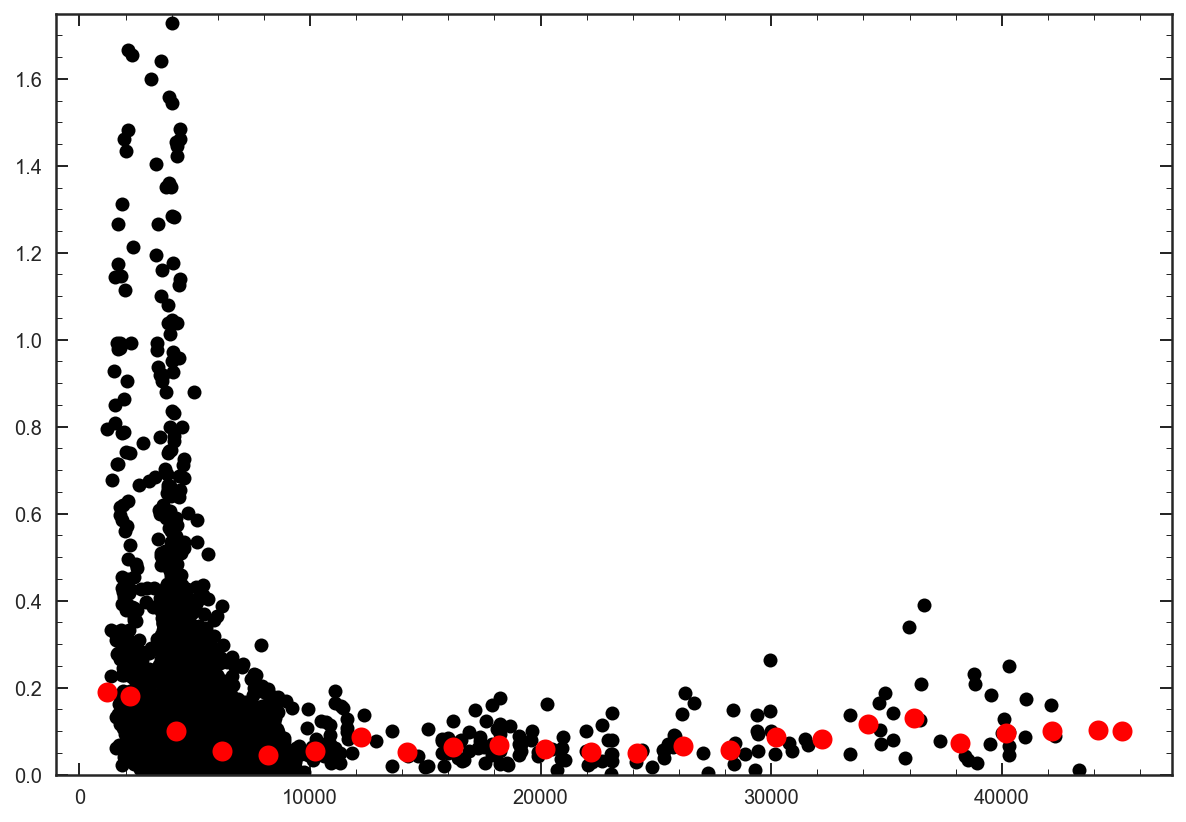

In [19]:
plt.figure(figsize=[10,7])
plt.plot(all_W[IDA], all_I[IDA], 'o', color='k')
plt.plot(AW, AI, 'o', color='r',ms=10)

# plt.plot(awv, amef)
# plt.plot(awv, amef,'o')
# plt.plot(awv, Smooth(amef,awv,500),'c',linewidth=5, alpha=0.3)
# plt.plot(all_mean, Smooth(all_bin,all_mean,1000),'c',linewidth=5, alpha=0.3)
plt.ylim(0,1.75)
# plt.xlim(0,4000)
# plt.xticks(np.log10([3000,5000,10000,25000,50000,100000]),[3000,5000,10000,25000,50000,100000])

In [97]:
awv = np.arange(500, max(PWV_rf) + 500, 500)
amef = [1.4,1.4, 0.4, 0.12, 0.09, 0.07, 0.06, 0.05, 0.035, 0.025, 0.02, 0.015,
       0.015, 0.015, 0.02, 0.03, 0.035, 0.04, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

# rwvs = np.arange(min(RWV), max(RWV) + 10, 5)
# irief = interp1d(rwv,rief)(rwvs)

In [100]:
awv,amef = np.load('../templates/mdl_EF.npy')

In [140]:
PWM = 10**PWVR_mean
PIM = np.sqrt(PME_bin-PE_bin)

BWM = BWVR_mean
BIM = np.sqrt(BME_bin-BE_bin)

RWM = RWVR_mean
RIM = np.sqrt(RME_bin-RE_bin)

PWM = PWM[PIM**2 > 0]
PIM = PIM[PIM**2 > 0]
BWM = BWM[BIM**2 > 0]
BIM = BIM[BIM**2 > 0]
RWM = RWM[RIM**2 > 0]
RIM = RIM[RIM**2 > 0]

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered

In [142]:
all_W = np.append(np.append(PWM,BWM),RWM)
all_I = np.append(np.append(PIM,BIM),RIM)

IDA = np.argsort(all_W)

(0, 4000)

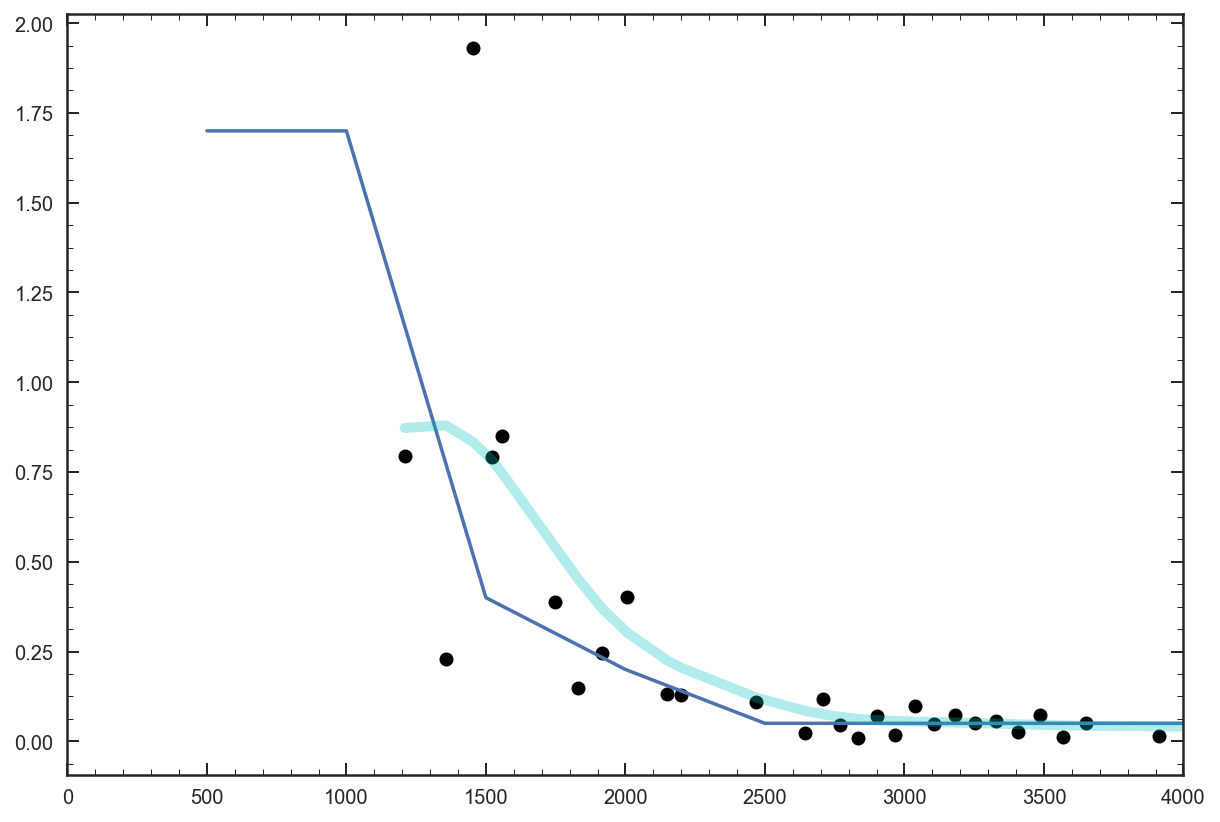

In [155]:
plt.figure(figsize=[10,7])
# plt.plot(PWM, PIM, 'o', color='#984ea3')
# plt.plot(BWM, BIM, 'o', color='#377eb8')
# plt.plot(RWM, RIM, 'o', color='#e41a1c')
plt.plot(all_W[IDA], all_I[IDA], 'o', color='k')
plt.plot(awv, amef)
# plt.plot(awv, amef,'o')
# plt.plot(awv, Smooth(amef,awv,500),'c',linewidth=5, alpha=0.3)
plt.plot(all_W[IDA], Smooth(all_I[IDA],all_W[IDA],300),'c',linewidth=5, alpha=0.3)

plt.xlim(0,4000)
# plt.xticks(np.log10([3000,5000,10000,25000,50000,100000]),[3000,5000,10000,25000,50000,100000])

In [135]:
awv = np.arange(500, max(PWV_rf) + 500, 500)
amef = [1.7,1.7, 0.4, 0.2, 0.05, 0.05, 0.05, 0.05, 0.035, 0.025, 0.02, 0.015,
       0.015, 0.015, 0.02, 0.03, 0.035, 0.04, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

In [215]:
np.save('../templates/mdl_EF',[AW,AI])

In [ ]:
PWV , BWV, RWV =[[],[],[]]
PIE , BIE, RIE =[[],[],[]]
PE , BE, RE =[[],[],[]]

for i in range(len(flist)):
    g1,g2,bfm,bfa,bft,bfz,bfd = np.load(flist[i])

    BFM, BFA, BFT, BFZ, BFD = np.array([bfm,bfa,bft,bfz,bfd]).astype(float)

    GS = Gen_spec(field[i],galaxy[i], BFZ,
                g102_lims=[7000, 12000], g141_lims=[10000, 18000], mdl_err = True, instr_err = True,phot_errterm = 0.3, decontam=True)
    GS.Sim_all(BFM/0.019, BFA, BFT, BFZ, BFD)

    PWV.extend(GS.Pwv)
    PIE.extend(((GS.Pflx - GS.Pmfl) / GS.Pflx)**2)
    PE.extend(((GS.Perr)/GS.Pflx)**2)

    if GS.g102: 
        BWV.extend(GS.Bwv)
        BIE.extend(((GS.Bfl - GS.Bmfl) / GS.Bfl)**2)
        BE.extend(((GS.Ber)/GS.Bfl)**2)

    if GS.g141: 
        RWV.extend(GS.Rwv)
        RIE.extend(((GS.Rfl - GS.Rmfl) / GS.Rfl)**2)
        RE.extend(((GS.Rer)/GS.Rfl)**2)

In [22]:
from dynesty.utils import quantile as _quantile
from scipy.ndimage import gaussian_filter as norm_kde

def Get_posterior(sample,logwt,logz):
    weight = np.exp(logwt - logz[-1])

    q = [0.5 - 0.5 * 0.999999426697, 0.5 + 0.5 * 0.999999426697]
    span = _quantile(sample.T, q, weights=weight)

    s = 0.02

    bins = int(round(10. / 0.02))
    n, b = np.histogram(sample, bins=bins, weights=weight,
                        range=np.sort(span))
    n = norm_kde(n, 10.)
    x0 = 0.5 * (b[1:] + b[:-1])
    y0 = n
    
    return x0, y0 / np.trapz(y0,x0)

In [30]:
T1,T2,T3,T4,T5,T6 = [[],[],[],[],[],[]]
Z=[]
for i in range(len(field)):
    dres = np.load('../data/out_dict/{0}_{1}_nested_Bfit.npy'.format(field[i], galaxy[i])).item()
    bfZ, bft, bftau1, bftau2, bftau3, bftau4, bftau5, bftau6, bfz, bfd =  dres.samples.T
    
    x,y = Get_posterior(bfz, dres.logwt, dres.logz)
    Z.append(x[y==max(y)][0])
    
    norm = bftau1 + bftau2 + bftau3 + bftau4 + bftau5 + bftau6
    
    tau1,bfTAU1 = Get_posterior(bftau1, dres.logwt, dres.logz)
    tau2,bfTAU2 = Get_posterior(bftau2, dres.logwt, dres.logz)
    tau3,bfTAU3 = Get_posterior(bftau3, dres.logwt, dres.logz)
    tau4,bfTAU4 = Get_posterior(bftau4, dres.logwt, dres.logz)
    tau5,bfTAU5 = Get_posterior(bftau5, dres.logwt, dres.logz)
    tau6,bfTAU6 = Get_posterior(bftau6, dres.logwt, dres.logz)
    
    tval1 = tau1[bfTAU1==max(bfTAU1)][0]
    tval2 = tau2[bfTAU2==max(bfTAU2)][0]
    tval3 = tau3[bfTAU3==max(bfTAU3)][0]
    tval4 = tau4[bfTAU4==max(bfTAU4)][0]
    tval5 = tau5[bfTAU5==max(bfTAU5)][0]
    tval6 = tau6[bfTAU6==max(bfTAU6)][0]
    
    norm = tval1 + tval2 + tval3 + tval4 + tval5 + tval6

    
    T1.append(tval1 / norm)
    T2.append(tval2 / norm)    
    T3.append(tval3 / norm)    
    T4.append(tval4 / norm)        
    T5.append(tval5 / norm)    
    T6.append(tval6 / norm)    

In [39]:
ULT1,ULT2,ULT3,ULT4,ULT5,ULT6 = [[],[],[],[],[],[]]
LT1,LT2,LT3,LT4,LT5,LT6 = [[],[],[],[],[],[]]
MT1,MT2,MT3,MT4,MT5,MT6 = [[],[],[],[],[],[]]
HT1,HT2,HT3,HT4,HT5,HT6 = [[],[],[],[],[],[]]
UHT1,UHT2,UHT3,UHT4,UHT5,UHT6 = [[],[],[],[],[],[]]

for i in range(len(Z)):
    if 0.7 < Z[i] < 1.0:
        ULT1.append(T1[i])
        ULT2.append(T2[i])    
        ULT3.append(T3[i])    
        ULT4.append(T4[i])        
        ULT5.append(T5[i])    
        ULT6.append(T6[i])
        
    if 1.0 < Z[i] < 1.2:
        LT1.append(T1[i])
        LT2.append(T2[i])    
        LT3.append(T3[i])    
        LT4.append(T4[i])        
        LT5.append(T5[i])    
        LT6.append(T6[i]) 
        
    if 1.2 < Z[i] < 1.4:
        MT1.append(T1[i])
        MT2.append(T2[i])    
        MT3.append(T3[i])    
        MT4.append(T4[i])        
        MT5.append(T5[i])    
        MT6.append(T6[i]) 
        
    if 1.4 < Z[i] < 1.6:
        HT1.append(T1[i])
        HT2.append(T2[i])    
        HT3.append(T3[i])    
        HT4.append(T4[i])        
        HT5.append(T5[i])    
        HT6.append(T6[i]) 
        
    if 1.6 < Z[i] < 1.9:
        UHT1.append(T1[i])
        UHT2.append(T2[i])    
        UHT3.append(T3[i])    
        UHT4.append(T4[i])        
        UHT5.append(T5[i])    
        UHT6.append(T6[i])

In [62]:
def Cumlative_dist(T1,T2,T3,T4,T5,T6):
    t1 = np.percentile(T1,50)
    t2 = np.percentile(T1,50)    
    t3 = np.percentile(T2,50)    
    t4 = np.percentile(T3,50)    
    t5 = np.percentile(T4,50)    
    t6 = np.percentile(T5,50)    
    
    norm = t1 + t2 + t3 + t4 + t5 + t6 
    
    return np.array([t1, t1, t1 + t2, t1 + t2 + t3, t1 + t2 + t3 +t4, t1 + t2 + t3 + t4 + t5, t1 + t2 + t3 + t4 + t5 + t6])/norm

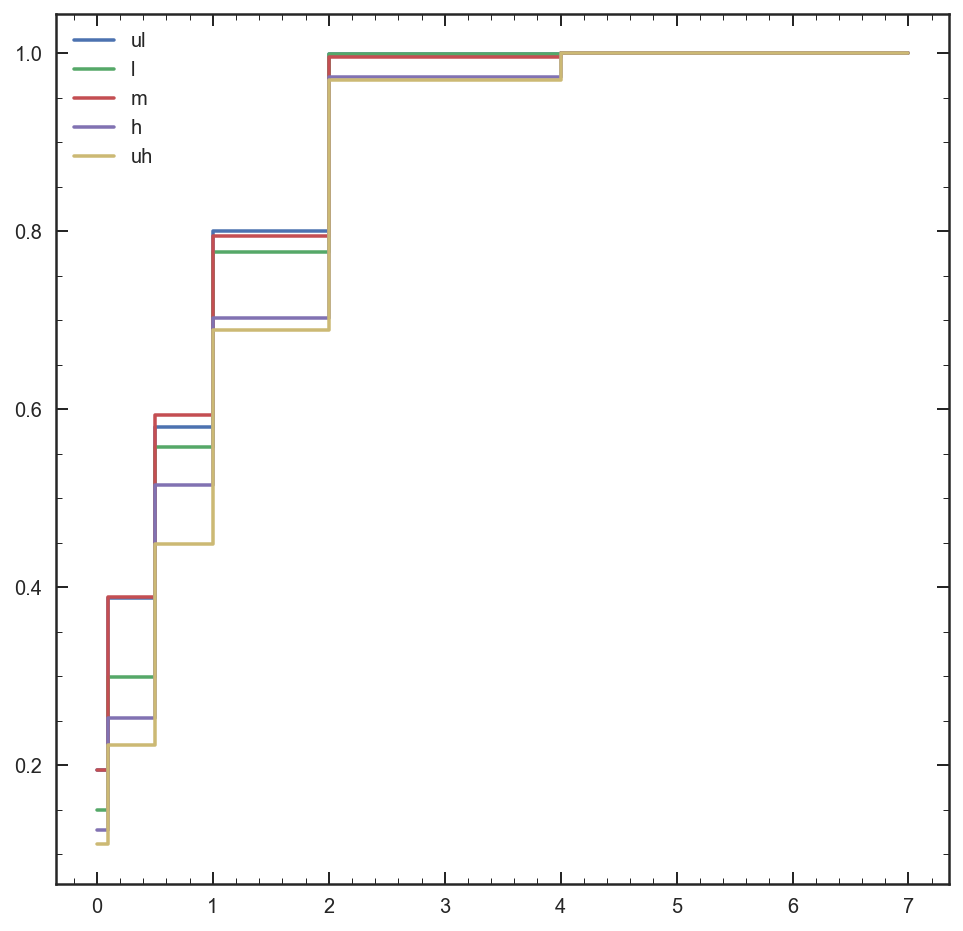

In [65]:
plt.figure(figsize=[8,8])
plt.step(np.array([0,0.1, 0.5, 1, 2, 4, 7]),
        Cumlative_dist(ULT1,ULT2,ULT3,ULT4,ULT5,ULT6), label = 'ul')

plt.step(np.array([0,0.1, 0.5, 1, 2, 4, 7]),
        Cumlative_dist(LT1,LT2,LT3,LT4,LT5,LT6), label = 'l')

plt.step(np.array([0,0.1, 0.5, 1, 2, 4, 7]),
        Cumlative_dist(MT1,MT2,MT3,MT4,MT5,MT6), label = 'm')

plt.step(np.array([0,0.1, 0.5, 1, 2, 4, 7]),
        Cumlative_dist(HT1,HT2,HT3,HT4,HT5,HT6), label = 'h')

plt.step(np.array([0,0.1, 0.5, 1, 2, 4, 7]),
        Cumlative_dist(UHT1,UHT2,UHT3,UHT4,UHT5,UHT6), label = 'uh')
plt.legend()
# plt.fill_between(np.array([0,0.1, 0.5, 1, 2, 4, 7]),
#                  np.percentile([ULT1,ULT1,ULT2,ULT3,ULT4,ULT5,ULT6],16,axis=1),
#                  np.percentile([ULT1,ULT1,ULT2,ULT3,ULT4,ULT5,ULT6],84,axis=1), 
#                  step = 'pre',alpha = .3)

# plt.figure(figsize=[8,8])
# plt.step(np.array([0,0.1, 0.5, 1, 2, 4, 7]),np.percentile([LT1,LT1,LT2,LT3,LT4,LT5,LT6],50,axis=1))

# plt.fill_between(np.array([0,0.1, 0.5, 1, 2, 4, 7]),
#                  np.percentile([LT1,LT1,LT2,LT3,LT4,LT5,LT6],16,axis=1),
#                  np.percentile([LT1,LT1,LT2,LT3,LT4,LT5,LT6],84,axis=1), 
#                  step = 'pre',alpha = .3)

# plt.figure(figsize=[8,8])
# plt.step(np.array([0,0.1, 0.5, 1, 2, 4, 7]),np.percentile([MT1,MT1,MT2,MT3,MT4,MT5,MT6],50,axis=1)) 

# plt.fill_between(np.array([0,0.1, 0.5, 1, 2, 4, 7]),
#                  np.percentile([MT1,MT1,MT2,MT3,MT4,MT5,MT6],16,axis=1),
#                  np.percentile([MT1,MT1,MT2,MT3,MT4,MT5,MT6],84,axis=1), 
#                  step = 'pre',alpha = .3)

# plt.figure(figsize=[8,8])
# plt.step(np.array([0,0.1, 0.5, 1, 2, 4, 7]),np.percentile([HT1,HT1,HT2,HT3,HT4,HT5,HT6],50,axis=1)) 

# plt.fill_between(np.array([0,0.1, 0.5, 1, 2, 4, 7]),
#                  np.percentile([HT1,HT1,HT2,HT3,HT4,HT5,HT6],16,axis=1),
#                  np.percentile([HT1,HT1,HT2,HT3,HT4,HT5,HT6],84,axis=1), 
#                  step = 'pre',alpha = .3)

# plt.figure(figsize=[8,8])
# plt.step(np.array([0,0.1, 0.5, 1, 2, 4, 7]),np.percentile([UHT1,UHT1,UHT2,UHT3,UHT4,UHT5,UHT6],50,axis=1)) 

# plt.fill_between(np.array([0,0.1, 0.5, 1, 2, 4, 7]),
#                  np.percentile([UHT1,UHT1,UHT2,UHT3,UHT4,UHT5,UHT6],16,axis=1),
#                  np.percentile([UHT1,UHT1,UHT2,UHT3,UHT4,UHT5,UHT6],84,axis=1), 
#                  step = 'pre',alpha = .3)

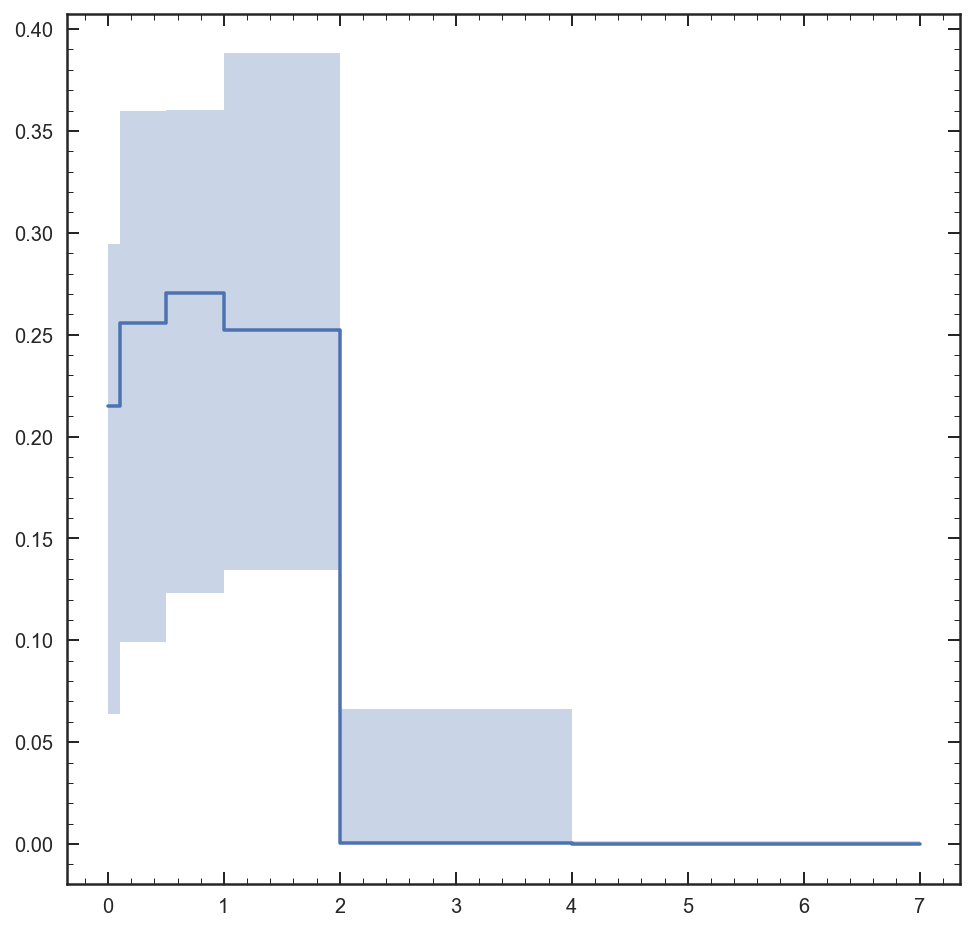

In [41]:
plt.figure(figsize=[8,8])
plt.step(np.array([0,0.1, 0.5, 1, 2, 4, 7]),np.percentile([T1,T1,T2,T3,T4,T5,T6],50,axis=1))

plt.fill_between(np.array([0,0.1, 0.5, 1, 2, 4, 7]),
                 np.percentile([T1,T1,T2,T3,T4,T5,T6],16,axis=1),
                 np.percentile([T1,T1,T2,T3,T4,T5,T6],84,axis=1), 
                 step = 'pre',alpha = .3)

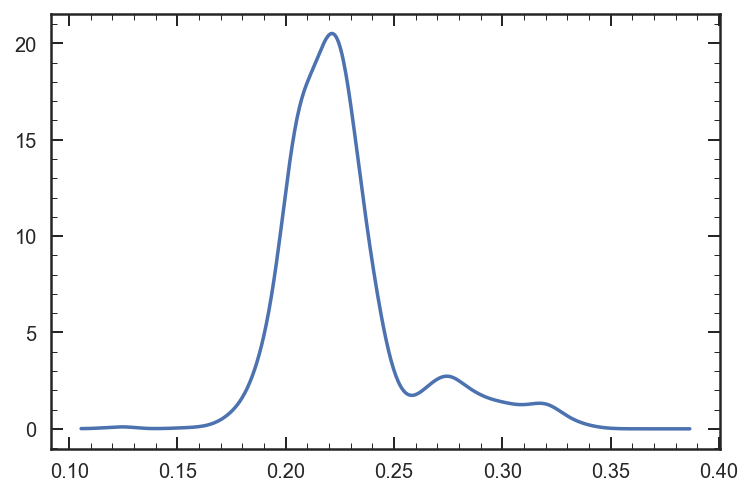

In [53]:
dres = np.load('../data/out_dict/GND_22774_nested_Bfit.npy').item()
bfZ, bft, bftau1, bftau2, bftau3, bftau4, bftau5, bftau6, bfz, bfd =  dres.samples.T

x,y = Get_posterior(bfZ, dres.logwt, dres.logz)
plt.plot(x,y)

x,y = Get_posterior(bfz, dres.logwt, dres.logz)
ZVAL = x[y==max(y)][0]

norm = bftau1 + bftau2 + bftau3 + bftau4 + bftau5 + bftau6

tau1,bfTAU1 = Get_posterior(bftau1, dres.logwt, dres.logz)
tau2,bfTAU2 = Get_posterior(bftau2, dres.logwt, dres.logz)
tau3,bfTAU3 = Get_posterior(bftau3, dres.logwt, dres.logz)
tau4,bfTAU4 = Get_posterior(bftau4, dres.logwt, dres.logz)
tau5,bfTAU5 = Get_posterior(bftau5, dres.logwt, dres.logz)
tau6,bfTAU6 = Get_posterior(bftau6, dres.logwt, dres.logz)

tval1 = tau1[bfTAU1==max(bfTAU1)][0]
tval2 = tau2[bfTAU2==max(bfTAU2)][0]
tval3 = tau3[bfTAU3==max(bfTAU3)][0]
tval4 = tau4[bfTAU4==max(bfTAU4)][0]
tval5 = tau5[bfTAU5==max(bfTAU5)][0]
tval6 = tau6[bfTAU6==max(bfTAU6)][0]

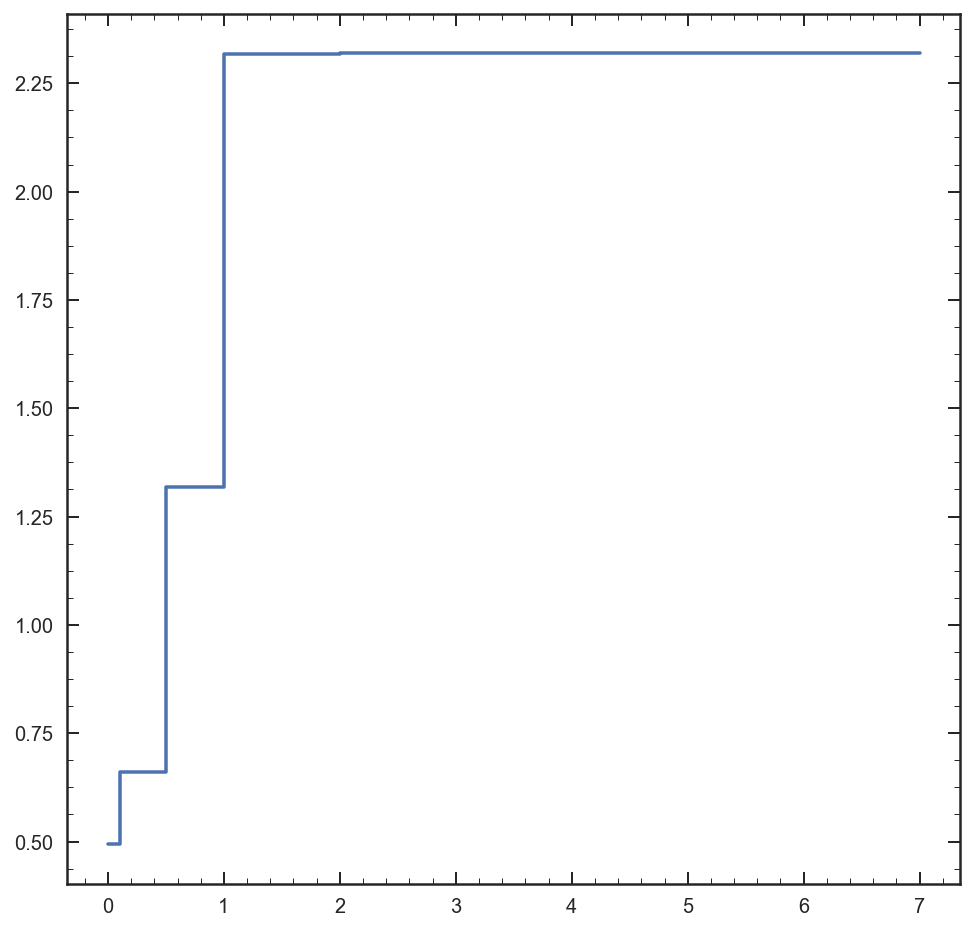

In [55]:
plt.figure(figsize=[8,8])
plt.step(np.array([0,0.1, 0.5, 1, 2, 4, 7]),
         [tval1,tval1,tval2 + tval1,tval3 + tval2 + tval1,tval4 + tval3 + tval2 + tval1,
          tval5 + tval4 + tval3 + tval2 + tval1,tval6 + tval5 + tval4 + tval3 + tval2 + tval1]) 